# Gradient Boosting

## Building a Classifier using Gradient Boosting

In [1]:
# Imports
import numpy as np 
from sklearn.model_selection import train_test_split 
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Settings
FIG_SIZE = (11,7)

In [3]:
# Defining Functions

# The ideal regressor line
def reg_line(x):
    return x * np.sin(x) + np.sin(2 * x)

# Generating trainning and testing data
def gen_data(n_samples = 200):
    
    # Generating random data
    np.random.seed(15)
    X = np.random.uniform(0, 10, size = n_samples)[:, np.newaxis]
    y = reg_line(X.ravel()) + np.random.normal(scale = 2, size = n_samples)

    # Splitting between trainning and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
    
    return X_train, X_test, y_train, y_test

In [4]:
# Creating datasets
X_train, X_test, y_train, y_test = gen_data(100)
X_train.shape, y_train.shape

((80, 1), (80,))

In [5]:
# Data to regressor line
x_plot = np.linspace(0,10,500)
x_plot

array([ 0.        ,  0.02004008,  0.04008016,  0.06012024,  0.08016032,
        0.1002004 ,  0.12024048,  0.14028056,  0.16032064,  0.18036072,
        0.2004008 ,  0.22044088,  0.24048096,  0.26052104,  0.28056112,
        0.3006012 ,  0.32064128,  0.34068136,  0.36072144,  0.38076152,
        0.4008016 ,  0.42084168,  0.44088176,  0.46092184,  0.48096192,
        0.501002  ,  0.52104208,  0.54108216,  0.56112224,  0.58116232,
        0.6012024 ,  0.62124248,  0.64128257,  0.66132265,  0.68136273,
        0.70140281,  0.72144289,  0.74148297,  0.76152305,  0.78156313,
        0.80160321,  0.82164329,  0.84168337,  0.86172345,  0.88176353,
        0.90180361,  0.92184369,  0.94188377,  0.96192385,  0.98196393,
        1.00200401,  1.02204409,  1.04208417,  1.06212425,  1.08216433,
        1.10220441,  1.12224449,  1.14228457,  1.16232465,  1.18236473,
        1.20240481,  1.22244489,  1.24248497,  1.26252505,  1.28256513,
        1.30260521,  1.32264529,  1.34268537,  1.36272545,  1.38

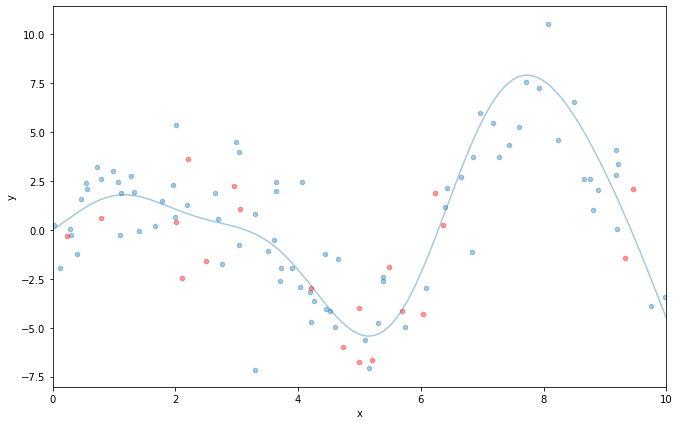

In [6]:
# Plotting Data
def plot_data(alpha = 0.4, s = 20):
    
    # Create figure
    fig = plt.figure(figsize = FIG_SIZE)
    
    # Generate plot
    gt = plt.plot(x_plot, reg_line(x_plot), alpha = alpha)
    
    # Plot of trainning and testing data
    plt.scatter(X_train, y_train, s=s, alpha = alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0,10))
    plt.xlabel('x')
    plt.ylabel('y')
    
# Formatting
annotation_kw = {
    'xycoords': 'data',
    'textcoords': 'data',
    'arrowprops':
        {
        'arrowstyle': '->',
        'connectionstyle': 'arc'
        }
}

# Plot
plot_data()
# Blue data -> Trainning
# Red data -> Testing

## Plot with 2 Decision Trees with different depth

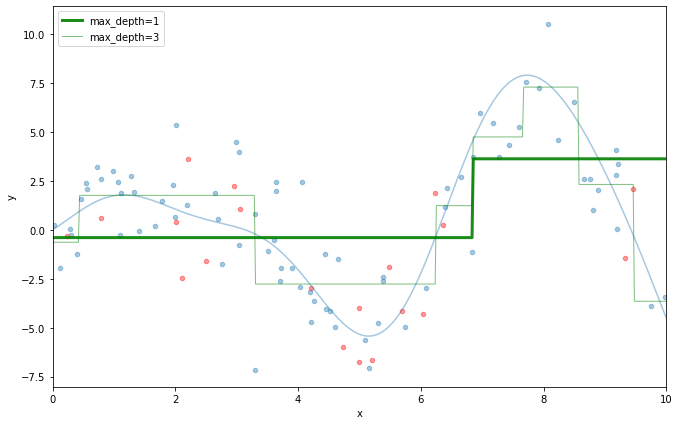

In [7]:
from sklearn.tree import DecisionTreeRegressor

plot_data()

# Decision tree (max_depth = 1)
est = DecisionTreeRegressor(max_depth = 1).fit(X_train, y_train)
plt.plot(x_plot, 
         est.predict(x_plot[:, np.newaxis]), 
         label = 'max_depth=1',
        color = 'g',
        alpha = 0.9,
        linewidth = 3)

# Decision tree (max_depth = 3)
est = DecisionTreeRegressor(max_depth = 3).fit(X_train, y_train)
plt.plot(x_plot, 
         est.predict(x_plot[:, np.newaxis]), 
         label = 'max_depth=3',
        color = 'g',
        alpha = 0.5,
        linewidth = 1)

# Legend
plt.legend(loc = 'upper left');

## Applying Gradient Boosting Regressor

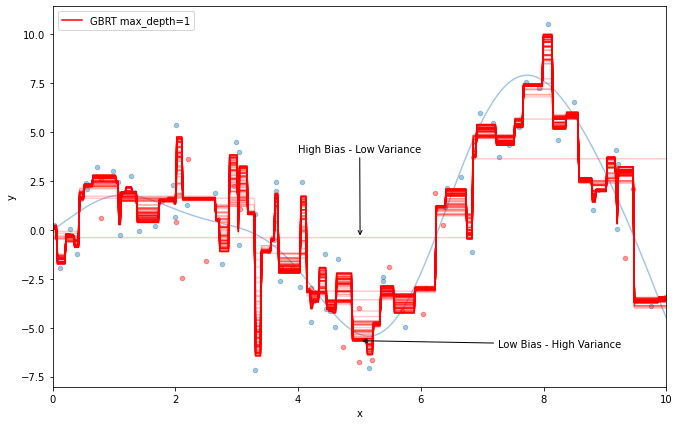

In [8]:
from itertools import islice
from sklearn.ensemble import GradientBoostingRegressor

plot_data()

# GBRT Regressor
est = GradientBoostingRegressor(n_estimators = 1000, max_depth=1, learning_rate = 1.0)

# Model
est.fit(X_train, y_train)
ax = plt.gca()
first = True

# Steps through predictions as we added more decision trees
# Using islice to tracking the evaluation of trainning
for pred in islice(est.staged_predict(x_plot[:,np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color = 'r', alpha = 0.2)
    if first:
        ax.annotate('High Bias - Low Variance',
                   xy = (x_plot[x_plot.shape[0]//2], pred[x_plot.shape[0]//2]),
                    xytext = (4,4),
                    **annotation_kw)
        first = False
        
# Predictions
pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color = 'r', label = 'GBRT max_depth=1')
ax.annotate('Low Bias - High Variance',
           xy = (x_plot[x_plot.shape[0] // 2], pred[x_plot.shape[0] // 2 ]),
          xytext = (7.25, -6),
          **annotation_kw)
    
# Posicao da Legenda
plt.legend(loc='upper left');

## Diagnosing if the model is with overfitting

In [9]:
# Defining the function to plot the graph
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', test_color='#d7191c', alpha=1.0, ylim = (0, 10)):
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)
    
    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)
    
    if ax is None:
        fig = plt.figure(figsize = FIG_SIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color = test_color, label = 'Test %s' % label, linewidth = 2, alpha = alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label = 'Training %s' % label, linewidth = 2, alpha = alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('Number of base estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

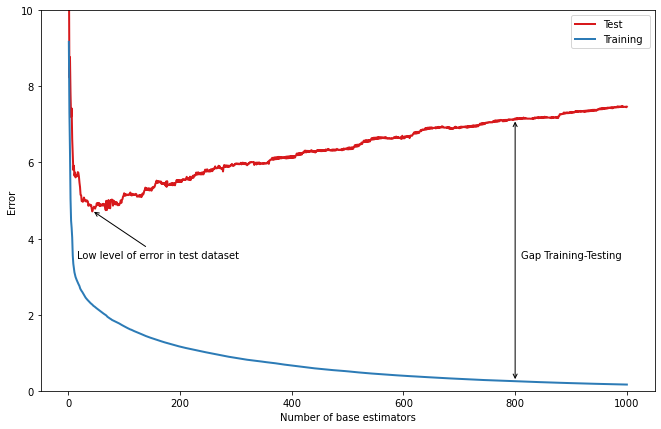

In [10]:
# Applying the deviance_plot and testing_data to measure the overfitting of the model
test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc = 'upper right')

# Legends
ax.annotate('Low level of error in test dataset',
           xy = (test_dev.argmin() + 1, test_dev.min() + 0.02),
           xytext = (15, 3.5),
           **annotation_kw)

ann = ax.annotate('', xy = (800, test_dev[799]),  xycoords = 'data',
                  xytext = (800, est.train_score_[799]), textcoords = 'data',
                  arrowprops = {'arrowstyle': '<->'})

ax.text(810, 3.5, 'Gap Training-Testing');

## Avoid Overfitting

### Altering decision tree structure, with shrinkage and with Stochastic Gradient Descent

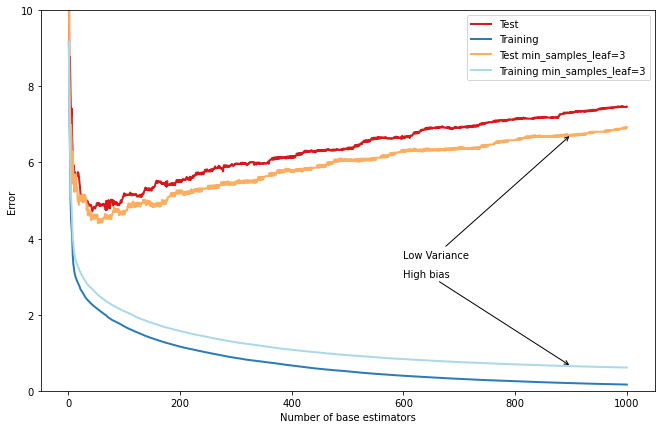

In [24]:
# Altering decision tree structure
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()

for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')), ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators = 1000, max_depth = 1, learning_rate = 1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est,
                                X_test,
                                y_test,
                                ax = ax,
                                label = fmt_params(params),
                                train_color = train_color,
                                test_color = test_color)
    
ax.annotate('High bias', xy = (900, est.train_score_[899]), xytext = (600,3), **annotation_kw)
ax.annotate('Low Variance', xy = (900, test_dev[899]), xytext = (600,3.5), **annotation_kw)
plt.legend(loc = 'upper right');

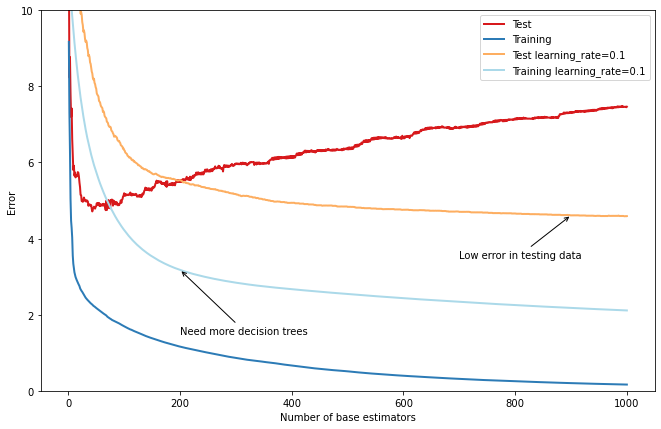

In [32]:
# Shrinkage
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()

for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')), ({'learning_rate': 0.1}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators = 1000, max_depth = 1, learning_rate = 1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est,
                                X_test,
                                y_test,
                                ax = ax,
                                label = fmt_params(params),
                                train_color = train_color,
                                test_color = test_color)
    
ax.annotate('Need more decision trees', xy = (200, est.train_score_[199]), xytext = (200,1.5), **annotation_kw)
ax.annotate('Low error in testing data', xy = (900, test_dev[899]), xytext = (700,3.5), **annotation_kw)
plt.legend(loc = 'upper right');

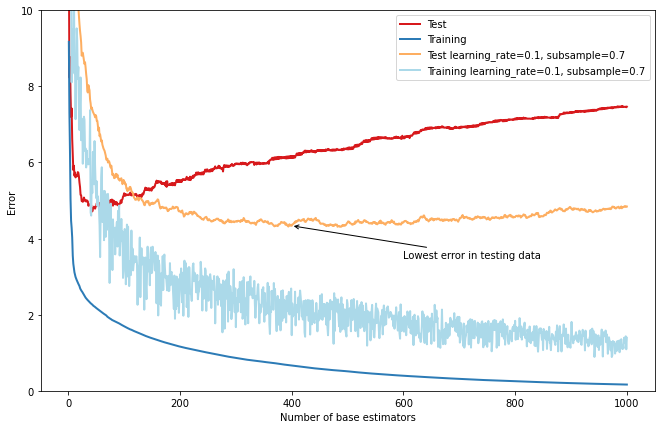

In [39]:
# Stochastic Gradient Boosting
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()

for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')), ({'learning_rate': 0.1, 'subsample': 0.7}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators = 1000, max_depth = 1, learning_rate = 1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est,
                                X_test,
                                y_test,
                                ax = ax,
                                label = fmt_params(params),
                                train_color = train_color,
                                test_color = test_color)
    
ax.annotate('Lowest error in testing data', xy = (400, test_dev[399]), xytext = (600,3.5), **annotation_kw)
plt.legend(loc = 'upper right');

## Tunning of hyperparameters with Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid of parameters
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 5, 6],
              'min_samples_leaf': [3, 4, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [400, 700, 1000, 2000, 3000]
              }

# Regressor
est = GradientBoostingRegressor()

# Model built with GridSearchCV
gs_cv = GridSearchCV(est,
                    param_grid,
                    scoring='neg_mean_squared_error',
                    n_jobs = 4).fit(X_train, y_train)

print('The best parameters are: %r' % gs_cv.best_params_)

The best parameters are: {'learning_rate': 0.001, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 3000, 'subsample': 0.5}


## Building the model with the best parameters

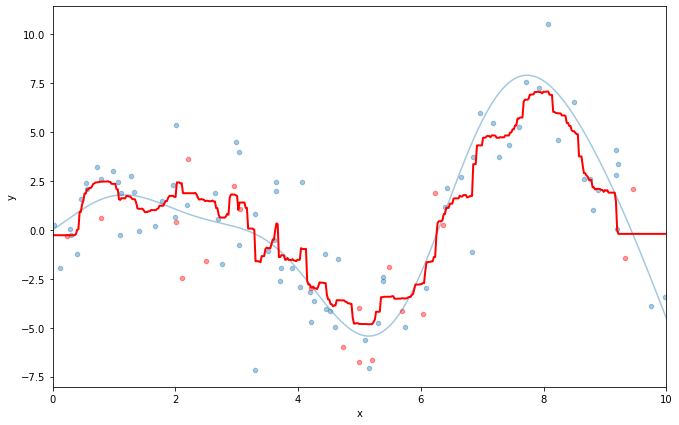

In [41]:
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)

plot_data()
plt.plot(x_plot, est.predict(x_plot[:,np.newaxis]), color='r', linewidth = 2)